In [1]:
import pandas as pd
import numpy as np

In [9]:
# 读取数据
output_file = 'D:\\FutureData\\ricequant\\1d_2017to2024_noadjust.h5'
df0 = pd.read_hdf(output_file, key='/MA').reset_index()
df1 = pd.read_hdf(output_file, key='/PP').reset_index()


In [17]:
import numpy as np

class KalmanFilter:
    def __init__(self):
        self.x = np.array([1.0])  # 初始系数（假设1:1配比）
        self.P = np.eye(1)        # 状态协方差
        self.Q = 0.01             # 过程噪声
        self.R = 0.1              # 观测噪声

    def update(self, z):
        # 预测步骤
        x_pred = self.x
        P_pred = self.P + self.Q

        # 更新步骤
        K = P_pred / (P_pred + self.R)
        self.x = x_pred + K * (z - x_pred)
        self.P = (1 - K) * P_pred
        return self.x[0]

def kalman_ratio(df1, df2):
    kf = KalmanFilter()
    spreads = []
    for p1, p2 in zip(df1, df2):
        if p2 != 0:
            ratio = p1 / p2  # 实时价格比
            beta = kf.update(ratio)
        spreads.append(p1 - beta * p2)

    # 取末段均值确定整数配比
    final_beta = np.mean(kf.x[-30:]) if len(df1) >30 else round(kf.x[-1])
    return simplify_ratio(final_beta), np.array(spreads)

kalman_ratio(df1.close,df0.close)

((25, 9),
 array([[531.71171171],
        [241.63814015],
        [180.71105   ],
        ...,
        [-31.38092881],
        [-81.91067103],
        [-57.64115829]]))

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
def simplify_ratio(ratio, max_denominator=10):
    """
    将浮点比例转换为最简整数比
    :param ratio: 浮点比例值
    :param max_denominator: 最大允许的分母值
    :return: (分子, 分母) 的元组
    """
    from fractions import Fraction
    frac = Fraction(ratio).limit_denominator(max_denominator)
    return (frac.numerator, frac.denominator)

def cointegration_ratio(df1, df2):

    # 协整回归
    X = sm.add_constant(df2)
    model = sm.OLS(df1, X).fit()
    beta = model.params[1] # 回归系数整数化
    spread = df1 - beta * df2  # 价差序列

    return simplify_ratio(beta), spread  # 配比格式(资产1单位:资产β单位)

cointegration_ratio(df1.close,df0.close)

C:\Users\flower\AppData\Local\Temp\ipykernel_8772\3933633177.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1] # 回归系数整数化


((13, 8),
 0       4250.271689
 1       4208.413727
 2       4242.987613
 3       4153.277424
 4       4246.924975
            ...     
 1938    3105.942179
 1939    3112.561500
 1940    3099.851310
 1941    3062.936444
 1942    3099.976144
 Name: close, Length: 1943, dtype: float64)

In [8]:
import statsmodels.api as sm
def cointegration_ratio(df1, df2):

    # 协整回归
    X = sm.add_constant(df2)
    model = sm.OLS(df1, X).fit()
    beta = model.params[1] # 回归系数整数化
    spread = df1 - beta * df2  # 价差序列

    return simplify_ratio(beta), spread  # 配比格式(资产1单位:资产β单位)

def simplify_ratio(ratio, max_denominator=10):
    """
    将浮点比例转换为最简整数比
    :param ratio: 浮点比例值
    :param max_denominator: 最大允许的分母值
    :return: (分子, 分母) 的元组
    """
    from fractions import Fraction
    frac = Fraction(ratio).limit_denominator(max_denominator)
    return (frac.numerator, frac.denominator)


In [23]:

def calculate_rolling_spread(df0, df1, window: int = 60):
    """滚动计算 β 和价差（spread）"""
    # 1. 对齐并合并价格
    df = (df0.set_index('date')['close']
              .rename('close0')
              .to_frame()
              .join(df1.set_index('date')['close']
                        .rename('close1'),
                    how='inner'))

    # 2. 计算滚动 β（向量化做法，比 rolling-apply 快很多）
    cov  = df['close0'].rolling(window).cov(df['close1'])
    var1 = df['close1'].rolling(window).var()
    beta = (cov / var1).round(1)

    # 3. 计算价差
    spread = df['close0'] - beta * df['close1']

    # 4. 整理输出
    out = (pd.DataFrame({'date': df.index,
                         'beta': beta,
                         'close': spread})
             .dropna()
             .reset_index(drop=True))
    return out

# 读取数据
output_file = 'D:\\FutureData\\ricequant\\1d_2017to2024_noadjust.h5'
df0 = pd.read_hdf(output_file, key='/J').reset_index()
df1 = pd.read_hdf(output_file, key='/JM').reset_index()

# 计算滚动价差
df_spread = calculate_rolling_spread(df0, df1, window=60)
print("滚动价差计算完成，系数示例：")
print(df_spread.head())


滚动价差计算完成，系数示例：
        date  beta   close
0 2017-04-05   1.9 -620.05
1 2017-04-06   1.9 -636.70
2 2017-04-07   1.9 -620.65
3 2017-04-10   1.9 -605.55
4 2017-04-11   1.9 -574.40


In [24]:
df_spread

,date,beta,close
0,2017-04-05,1.9,-620.05
1,2017-04-06,1.9,-636.70
2,2017-04-07,1.9,-620.65
3,2017-04-10,1.9,-605.55
4,2017-04-11,1.9,-574.40
...,...,...,...
1879,2024-12-25,1.1,549.20
1880,2024-12-26,1.1,550.40
1881,2024-12-27,1.1,526.00
1882,2024-12-30,1.0,641.00


In [11]:
df0

,underlying_symbol,date,dominant_id,open,close,high,low,total_turnover,volume,prev_close,settlement,prev_settlement,open_interest,limit_up,limit_down,day_session_open
0,J,2017-01-03,J1705,1519.0,1480.5,1595.0,1476.0,1.487567e+10,97848.0,1518.0,1520.0,1538.0,143064.0,1676.0,1400.0,1519.0
1,J,2017-01-04,J1705,1488.0,1495.0,1505.5,1442.0,1.926395e+10,130410.0,1480.5,1477.0,1520.0,145968.0,1656.5,1383.5,1468.0
2,J,2017-01-05,J1705,1493.0,1506.5,1527.0,1485.0,1.343434e+10,89294.0,1495.0,1504.5,1477.0,132964.0,1609.5,1344.5,1502.0
3,J,2017-01-06,J1705,1501.0,1532.0,1568.0,1486.0,1.882877e+10,123202.0,1506.5,1528.0,1504.5,134196.0,1639.5,1369.5,1507.0
4,J,2017-01-09,J1705,1540.0,1589.0,1589.5,1512.0,1.605840e+10,103720.0,1532.0,1548.0,1528.0,123670.0,1665.5,1390.5,1518.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,J,2024-12-25,J2505,1824.5,1817.5,1839.0,1805.0,3.159435e+09,17369.0,1824.5,1819.0,1810.0,24904.0,1954.5,1665.5,1830.0
1939,J,2024-12-26,J2505,1824.5,1805.5,1830.0,1803.0,2.712152e+09,14927.0,1817.5,1816.5,1819.0,26321.0,1964.5,1673.5,1821.0
1940,J,2024-12-27,J2505,1800.0,1780.0,1806.0,1773.0,3.577917e+09,20046.0,1805.5,1784.5,1816.5,30107.0,1961.5,1671.5,1788.0
1941,J,2024-12-30,J2505,1781.0,1798.5,1799.0,1766.0,2.765209e+09,15476.0,1780.0,1786.5,1784.5,29103.0,1927.0,1642.0,1782.0


In [17]:
df0.date

0      2017-01-03
1      2017-01-04
2      2017-01-05
3      2017-01-06
4      2017-01-09
          ...    
1938   2024-12-25
1939   2024-12-26
1940   2024-12-27
1941   2024-12-30
1942   2024-12-31
Name: date, Length: 1943, dtype: datetime64[ns]

In [2]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 读取数据
output_file = 'D:\\FutureData\\ricequant\\1d_2017to2024_noadjust.h5'
df0 = pd.read_hdf(output_file, key='/J').reset_index()
df1 = pd.read_hdf(output_file, key='/JM').reset_index()

# 确保日期列格式正确
df0['date'] = pd.to_datetime(df0['date'])
df1['date'] = pd.to_datetime(df1['date'])

# 显示数据头部
print("J合约数据：")
df0.head()

J合约数据：


,underlying_symbol,date,dominant_id,open,close,high,low,total_turnover,volume,prev_close,settlement,prev_settlement,open_interest,limit_up,limit_down,day_session_open
0,J,2017-01-03,J1705,1519.0,1480.5,1595.0,1476.0,1.487567e+10,97848.0,1518.0,1520.0,1538.0,143064.0,1676.0,1400.0,1519.0
1,J,2017-01-04,J1705,1488.0,1495.0,1505.5,1442.0,1.926395e+10,130410.0,1480.5,1477.0,1520.0,145968.0,1656.5,1383.5,1468.0
2,J,2017-01-05,J1705,1493.0,1506.5,1527.0,1485.0,1.343434e+10,89294.0,1495.0,1504.5,1477.0,132964.0,1609.5,1344.5,1502.0
3,J,2017-01-06,J1705,1501.0,1532.0,1568.0,1486.0,1.882877e+10,123202.0,1506.5,1528.0,1504.5,134196.0,1639.5,1369.5,1507.0
4,J,2017-01-09,J1705,1540.0,1589.0,1589.5,1512.0,1.605840e+10,103720.0,1532.0,1548.0,1528.0,123670.0,1665.5,1390.5,1518.5


In [4]:
def calculate_rolling_spread(
        df0: pd.DataFrame,          # 必含 'date' 与价格列
        df1: pd.DataFrame,
        window: int = 30,
        fields=('open', 'high', 'low', 'close')
    ) -> pd.DataFrame:
    """
    计算滚动 β，并为指定价格字段生成价差 (spread)：
        spread_x = price0_x - β_{t-1} * price1_x
    """
    # 1) 用收盘价对齐合并（β 仍用 close 估计）
    df = (df0.set_index('date')[['close']]
              .rename(columns={'close': 'close0'})
              .join(df1.set_index('date')[['close']]
                        .rename(columns={'close': 'close1'}),
                    how='inner'))

    # 2) 估计 β_t ，再向前挪一天
    beta_raw = df['close0'].rolling(window).cov(df['close1']) / \
               df['close1'].rolling(window).var()
    beta_shift = beta_raw.shift(1).round(1)        # 防未来 + 保留 1 位小数

    # 3) 把 β 拼回主表（便于后面 vectorized 计算）
    df = df.assign(beta=beta_shift)

    # 4) 对每个字段算 spread
    out_cols = {'date': df.index, 'beta': beta_shift}
    for f in fields:
        if f not in ('open','high','low','close'):
            raise ValueError(f'未知字段 {f}')
        p0 = df0.set_index('date')[f]
        p1 = df1.set_index('date')[f]
        aligned = p0.to_frame(name=f'price0_{f}').join(
                  p1.to_frame(name=f'price1_{f}'), how='inner')
        spread_f = aligned[f'price0_{f}'] - beta_shift * aligned[f'price1_{f}']
        out_cols[f'{f}'] = spread_f

    # 5) 整理输出
    out = (pd.DataFrame(out_cols)
             .dropna()
             .reset_index(drop=True))
    out['date'] = pd.to_datetime(out['date'])
    return out

# 计算滚动价差
spread_window = 30
df_spread = calculate_rolling_spread(df0, df1, window=spread_window)

print("价差数据示例：")
df_spread.head()

价差数据示例：


,date,beta,open,high,low,close
0,2017-02-21,1.6,-285.0,-290.80,-282.0,-292.80
1,2017-02-22,1.6,-289.3,-292.00,-289.2,-291.10
2,2017-02-23,1.6,-293.7,-289.80,-272.7,-265.40
3,2017-02-24,1.5,-146.5,-166.25,-161.0,-170.25
4,2017-02-27,1.5,-165.5,-173.50,-175.5,-161.00


C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\2877925423.py:27: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-

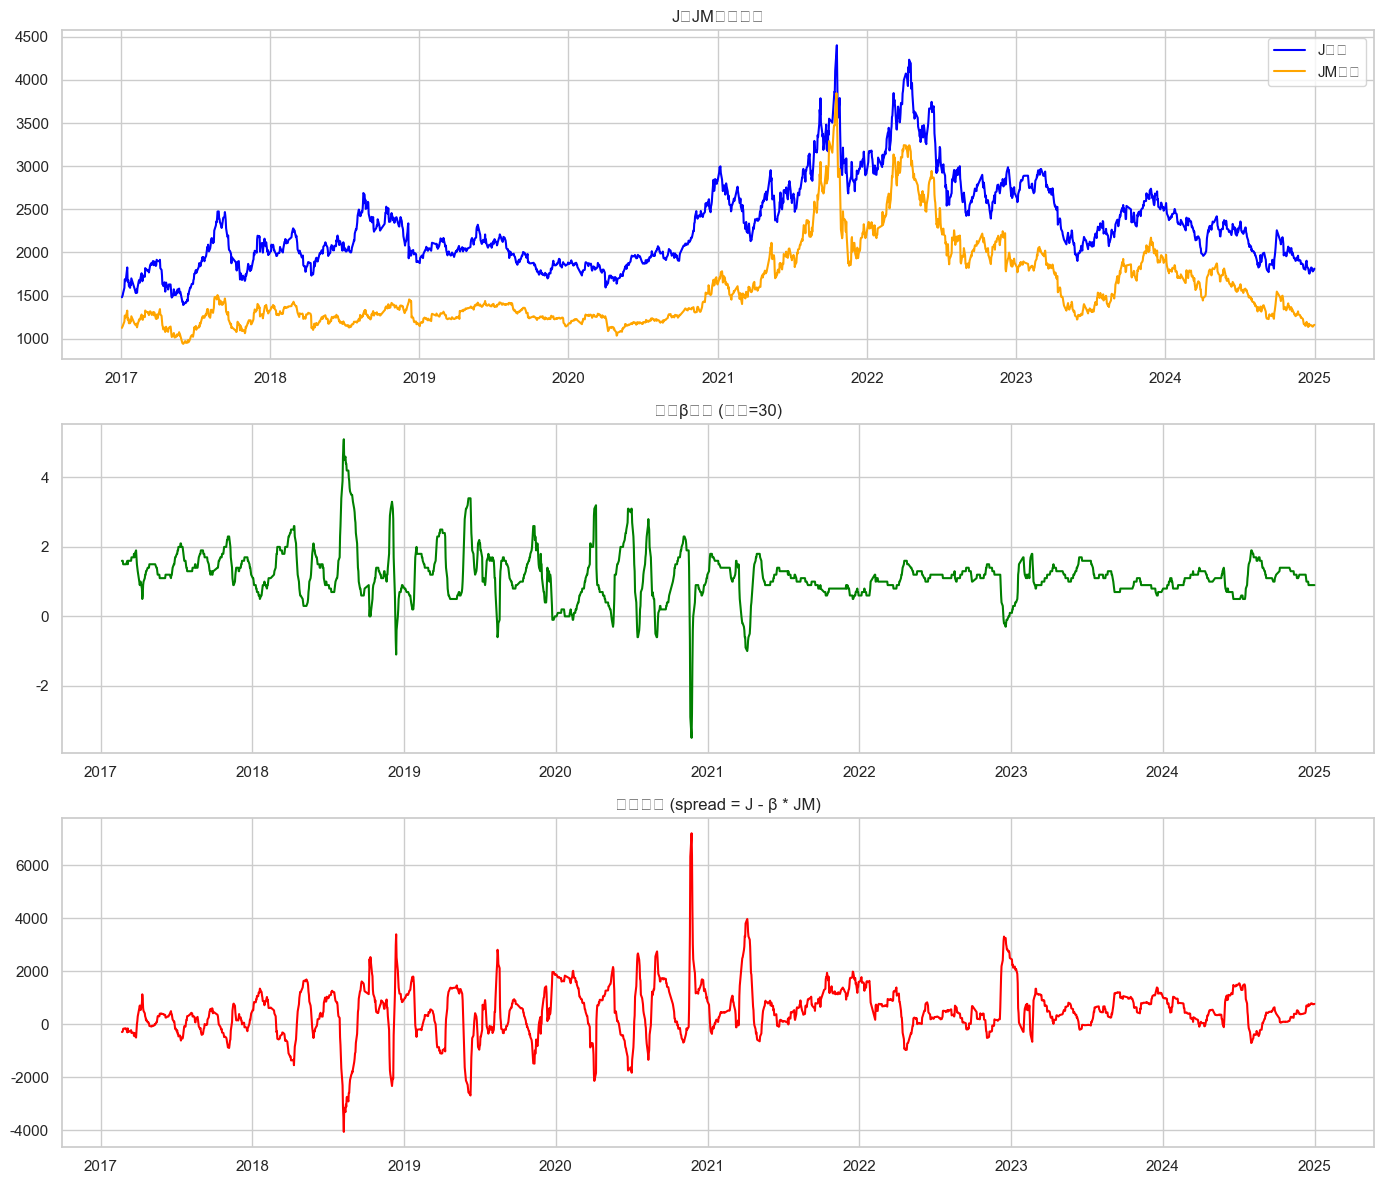

In [5]:
# 设置绘图风格
sns.set(style="whitegrid")

# 创建画布
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 绘制J和JM原始价格
ax1 = axes[0]
ax1.plot(df0['date'], df0['close'], label='J价格', color='blue')
ax1.plot(df1['date'], df1['close'], label='JM价格', color='orange')
ax1.set_title('J和JM原始价格')
ax1.legend()
ax1.grid(True)

# 绘制动态beta系数
ax2 = axes[1]
ax2.plot(df_spread['date'], df_spread['beta'], color='green')
ax2.set_title(f'动态β系数 (窗口={spread_window})')
ax2.grid(True)

# 绘制价差
ax3 = axes[2]
ax3.plot(df_spread['date'], df_spread['close'], color='red')
ax3.set_title(f'价差序列 (spread = J - β * JM)')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [9]:
for i in range(win, len(df_result)):
    # 使用前win个数据计算均值和标准差
    hist = df_result.loc[i-win:i-1, 'close'].values
    mu = np.mean(hist)        # 新增：计算滚动均值
    sigma = np.std(hist, ddof=1)
    
    if np.isnan(sigma) or sigma == 0:
        continue
        
    # 计算kappa和h（保持不变）
    kappa = k_coeff * sigma
    h = h_coeff * sigma
    
    # 记录均值mu（新增）
    df_result.loc[i, 'mu'] = mu       # 可选：将mu存入DataFrame
    
    # 获取当前价差并修正均值（关键修改）
    s_t = df_result.loc[i, 'close']
    s_t_corrected = s_t - mu          # 修正后的价差
    
    # 更新g_pos和g_neg（使用修正后的价差）
    if i > win:
        g_pos_prev = df_result.loc[i-1, 'g_pos']
        g_neg_prev = df_result.loc[i-1, 'g_neg']
        
        df_result.loc[i, 'g_pos'] = max(0, g_pos_prev + s_t_corrected - kappa)  # 修改
        df_result.loc[i, 'g_neg'] = max(0, g_neg_prev - s_t_corrected - kappa)  # 修改
    
    # 生成交易信号（逻辑不变）
    if df_result.loc[i, 'g_pos'] > h:
        df_result.loc[i, 'signal'] = -1
        df_result.loc[i, 'g_pos'] = 0  # 重置
        df_result.loc[i, 'g_neg'] = 0
    elif df_result.loc[i, 'g_neg'] > h:
        df_result.loc[i, 'signal'] = 1
        df_result.loc[i, 'g_pos'] = 0
        df_result.loc[i, 'g_neg'] = 0

C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 20570 (\N{CJK UNIFIED IDEOGRAPH-505A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\flower\AppData\Local\Temp\ipykernel_43664\3503485660.py:43: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-

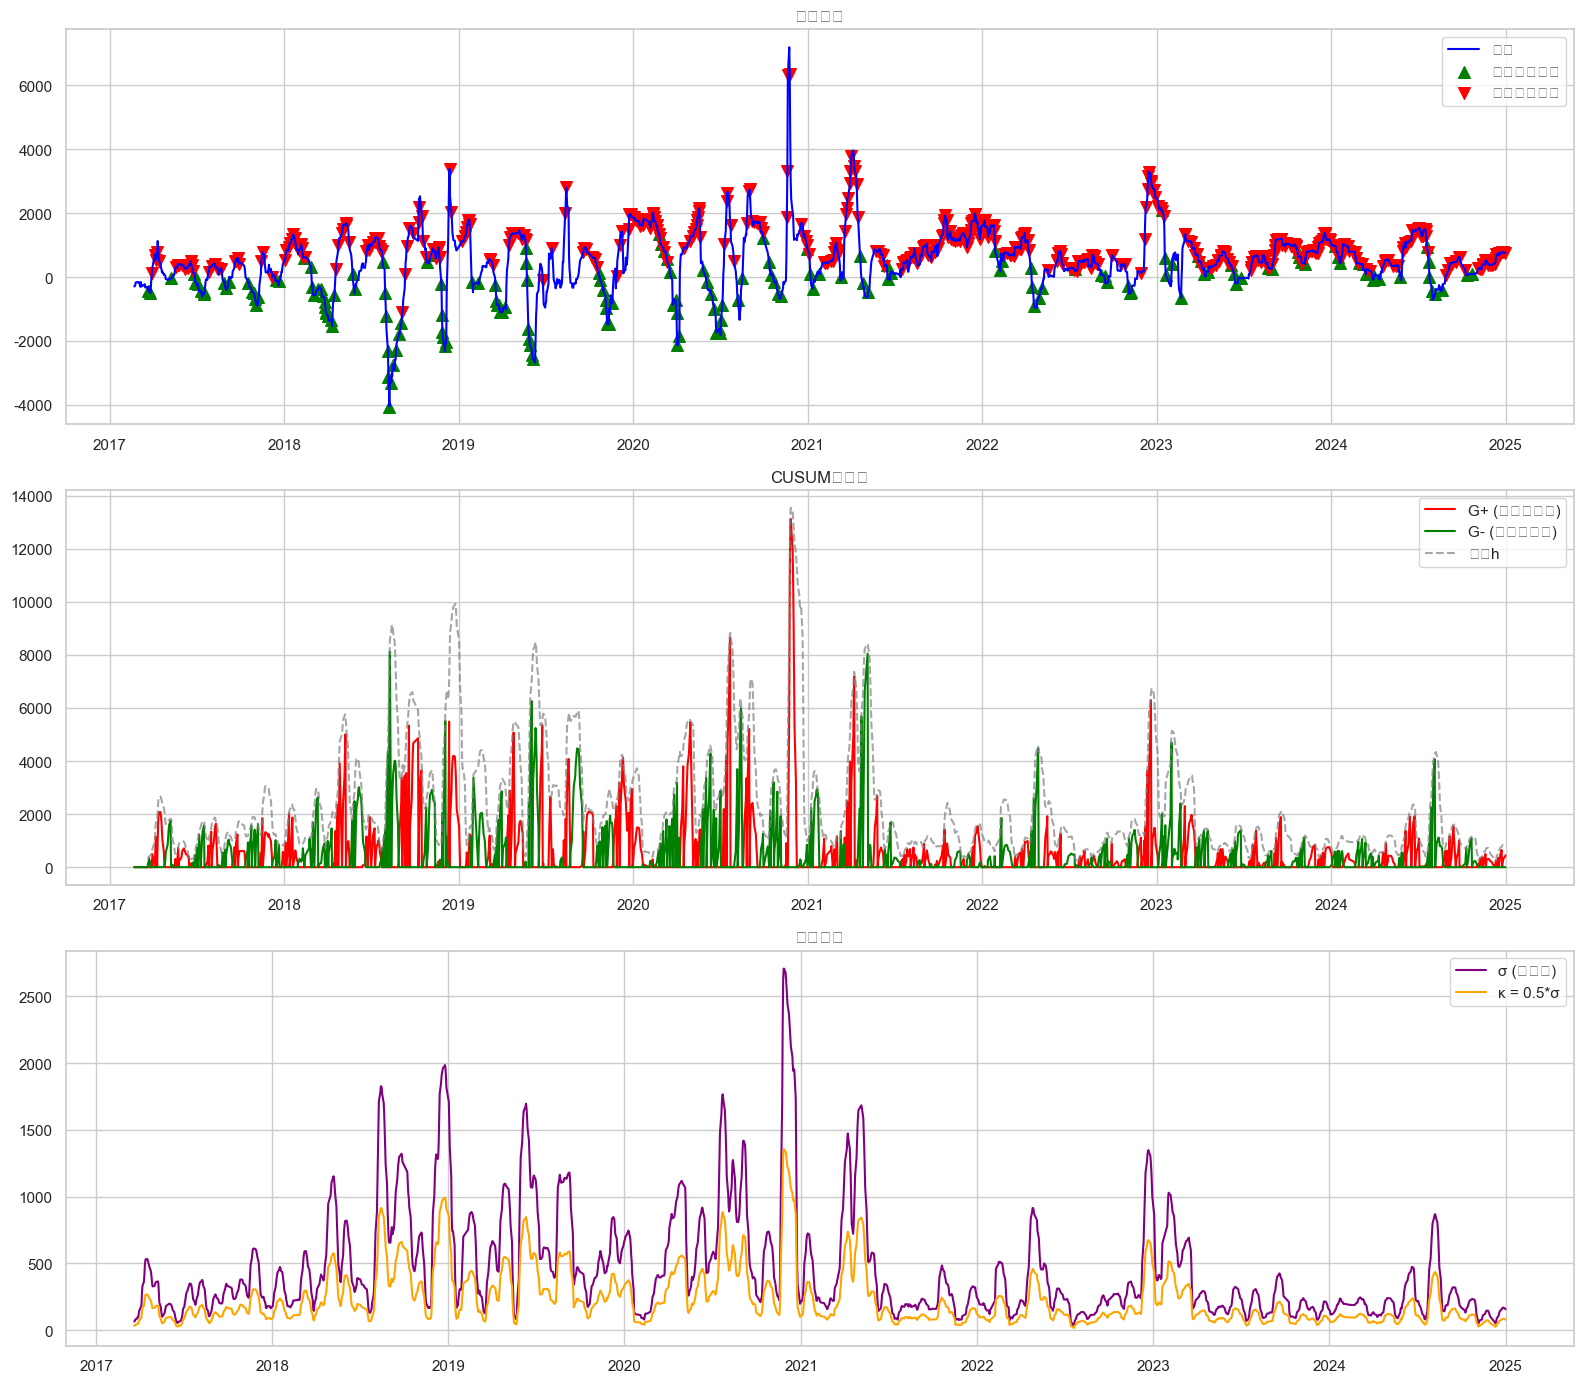

In [10]:
# 创建画布
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 绘制价差和动态阈值
ax1 = axes[0]
ax1.plot(df_result['date'], df_result['close'], label='价差', color='blue')
ax1.set_title('价差序列')
ax1.grid(True)

# 找出做多做空信号点
buy_signals = df_result[df_result['signal'] == 1]
sell_signals = df_result[df_result['signal'] == -1]

# 在价差图上标记交易信号
ax1.scatter(buy_signals['date'], buy_signals['close'], 
           color='green', s=70, marker='^', label='做多价差信号')
ax1.scatter(sell_signals['date'], sell_signals['close'], 
           color='red', s=70, marker='v', label='做空价差信号')
ax1.legend()

# 绘制CUSUM累积和
ax2 = axes[1]
ax2.plot(df_result['date'], df_result['g_pos'], label='G+ (正向累积和)', color='red')
ax2.plot(df_result['date'], df_result['g_neg'], label='G- (负向累积和)', color='green')
ax2.set_title('CUSUM统计量')
ax2.legend()
ax2.grid(True)

# 在G+/G-图上绘制动态阈值h
valid_h = df_result[~df_result['h'].isna()]
ax2.plot(valid_h['date'], valid_h['h'], '--', label='阈值h', color='gray', alpha=0.7)
ax2.legend()

# 绘制动态参数
ax3 = axes[2]
valid_data = df_result[~df_result['sigma'].isna()]
ax3.plot(valid_data['date'], valid_data['sigma'], label='σ (标准差)', color='purple')
ax3.plot(valid_data['date'], valid_data['kappa'], label='κ = 0.5*σ', color='orange')
ax3.set_title('动态参数')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# 统计交易信号数量
buy_count = len(buy_signals)
sell_count = len(sell_signals)
total_signals = buy_count + sell_count

print(f"做多价差信号数量: {buy_count}")
print(f"做空价差信号数量: {sell_count}")
print(f"总交易信号数量: {total_signals}")

# 计算简单收益指标（仅作示例，实际需要完整回测）
if total_signals > 0:
    print(f"\n参数设置:")
    print(f"- 价差计算窗口: {spread_window}")
    print(f"- Rolling窗口 (win): {win}")
    print(f"- κ系数 (k_coeff): {k_coeff}")
    print(f"- h系数 (h_coeff): {h_coeff}")

做多价差信号数量: 174
做空价差信号数量: 567
总交易信号数量: 741

参数设置:
- 价差计算窗口: 30
- Rolling窗口 (win): 20
- κ系数 (k_coeff): 0.5
- h系数 (h_coeff): 5.0
